# LinearRegression model 2016 Zillow

- Columns were divided into 'category' and 'scalar' depending on the data type.
- Column that has rate of NaN of 'category' data lower than 50% is filled most frequent value
- Column that has rate of NaN of 'category' data bigger than 50% is filled 0 value, because it seems that the Column means exist or not
- Columns of 'scalar' are filled with MICE Imputation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.imputation.mice import MICEData

%matplotlib inline

## Load Data

In [2]:
train_2016 = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
print(train_2016.shape)
train_2016.tail()

(90275, 3)


,parcelid,logerror,transactiondate
90270,10774160,-0.0356,2016-12-30
90271,12046695,0.0070,2016-12-30
90272,12995401,-0.2679,2016-12-30
90273,11402105,0.0602,2016-12-30
90274,12566293,0.4207,2016-12-30


In [3]:
property_2016 = pd.read_csv("properties_2016.csv", low_memory=False)
print(property_2016.shape)
property_2016.tail()

(2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985216,168040430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing

### parse date

In [4]:
train_2016["transactionyear"] = train_2016["transactiondate"].dt.year
train_2016["transactionmonth"] = train_2016["transactiondate"].dt.month
train_2016["transactionday"] = train_2016["transactiondate"].dt.day

train_2016.head()

,parcelid,logerror,transactiondate,transactionyear,transactionmonth,transactionday
0,11016594,0.0276,2016-01-01,2016,1,1
1,14366692,-0.1684,2016-01-01,2016,1,1
2,12098116,-0.0040,2016-01-01,2016,1,1
3,12643413,0.0218,2016-01-02,2016,1,2
4,14432541,-0.0050,2016-01-02,2016,1,2


### join data ( train_2016 & property_2016 )
- make train data

In [5]:
train = train_2016.set_index("parcelid").join(property_2016.set_index("parcelid"))
print(train.shape)
train.head()

(90275, 62)


,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,
10711738,0.0276,2016-08-02,2016,8,2,1.0,NaN,NaN,3.0,4.0,...,NaN,NaN,245180.0,567112.0,2015.0,321932.0,7219.18,NaN,NaN,6.037113e+13
10711755,-0.0182,2016-08-02,2016,8,2,1.0,NaN,NaN,3.0,3.0,...,NaN,NaN,254691.0,459844.0,2015.0,205153.0,6901.09,NaN,NaN,6.037113e+13
10711805,-0.1009,2016-05-03,2016,5,3,1.0,NaN,NaN,2.0,3.0,...,NaN,NaN,235114.0,384787.0,2015.0,149673.0,4876.61,NaN,NaN,6.037113e+13
10711816,-0.0121,2016-04-05,2016,4,5,1.0,NaN,NaN,2.0,4.0,...,NaN,NaN,262309.0,437176.0,2015.0,174867.0,5560.07,NaN,NaN,6.037113e+13
10711858,-0.0481,2016-07-15,2016,7,15,1.0,NaN,NaN,2.0,4.0,...,NaN,NaN,232037.0,382055.0,2015.0,150018.0,4878.25,NaN,NaN,6.037113e+13


### Fill in NaN value - train
- object type value preprocessing
- float, int type value preprocessing

In [6]:
print(len(train.dtypes[train.dtypes == object]))
train.dtypes[train.dtypes == object]

5


hashottuborspa               object
propertycountylandusecode    object
propertyzoningdesc           object
fireplaceflag                object
taxdelinquencyflag           object
dtype: object

In [7]:
object_columns = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
print(train[object_columns].shape)
train[object_columns].head()

(90275, 5)


,hashottuborspa,propertycountylandusecode,propertyzoningdesc,fireplaceflag,taxdelinquencyflag
parcelid,,,,,
10711738,NaN,0101,LARE11,NaN,NaN
10711755,NaN,0101,LARE11,NaN,NaN
10711805,NaN,0101,LARE9,NaN,NaN
10711816,NaN,0100,LARE9,NaN,NaN
10711858,NaN,0101,LARE9,NaN,NaN


- hashottuborspa : True or False
- propertycountylandusecode : 240 types
- propertyzoningdesc : 5638 types
- fireplaceflag : True or False
- taxdelinquencyflag : Y / N

**fill nan**
- hashottuborspa : True or False  ----------------------------->    True = 1, NaN = 0(False)
- fireplaceflag : True or False     ----------------------------->   True = 1, NaN = 0(False)
- taxdelinquencyflag : Y / N           ----------------------------->   Y = 1, NaN = 0(N)
- propertycountylandusecode : not yet preprocessing
- propertyzoningdesc : not yet preprocessing

#### hashottuborspa

In [8]:
# hashottuborspa
train.loc[~train["hashottuborspa"].isna(), "hashottuborspa"] = 1
train.loc[train["hashottuborspa"].isna(), "hashottuborspa"] = 0

train[train["hashottuborspa"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


#### fireplaceflag

In [9]:
# fireplaceflag
train.loc[~train["fireplaceflag"].isna(), "fireplaceflag"] = 1
train.loc[train["fireplaceflag"].isna(), "fireplaceflag"] = 0

train[train["fireplaceflag"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


#### taxdelinquencyflag

In [10]:
# taxdelinquencyflag
train.loc[~train["taxdelinquencyflag"].isna(), "taxdelinquencyflag"] = 1
train.loc[train["taxdelinquencyflag"].isna(), "taxdelinquencyflag"] = 0

train[train["taxdelinquencyflag"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


In [11]:
train[object_columns].dtypes

hashottuborspa                int64
propertycountylandusecode    object
propertyzoningdesc           object
fireplaceflag                 int64
taxdelinquencyflag            int64
dtype: object

In [12]:
# propertycountylandusecode

In [13]:
# propertyzoningdesc

In [14]:
print(len(train.dtypes[train.dtypes != object]))
train.dtypes[train.dtypes != object]

60


logerror                               float64
transactiondate                 datetime64[ns]
transactionyear                          int64
transactionmonth                         int64
transactionday                           int64
airconditioningtypeid                  float64
architecturalstyletypeid               float64
basementsqft                           float64
bathroomcnt                            float64
bedroomcnt                             float64
buildingclasstypeid                    float64
buildingqualitytypeid                  float64
calculatedbathnbr                      float64
decktypeid                             float64
finishedfloor1squarefeet               float64
calculatedfinishedsquarefeet           float64
finishedsquarefeet12                   float64
finishedsquarefeet13                   float64
finishedsquarefeet15                   float64
finishedsquarefeet50                   float64
finishedsquarefeet6                    float64
fips         

### Divide column 'Category' and 'Scalar'
- All of assessmentyear value is 2015.0, it means that assessmentyear has not effect for logerror

In [15]:
execept_columns = ["assessmentyear", "propertycountylandusecode", "propertyzoningdesc"]

category_columns = ["airconditioningtypeid", "architecturalstyletypeid", "buildingclasstypeid",\
                    "buildingqualitytypeid", "decktypeid", "fips", "fireplaceflag", "hashottuborspa",\
                    "heatingorsystemtypeid", "pooltypeid10", "pooltypeid2", "pooltypeid7",\
                    "propertylandusetypeid", "rawcensustractandblock", "censustractandblock",\
                    "regionidcounty", "regionidcity", "regionidzip", "regionidneighborhood", "storytypeid",\
                    "typeconstructiontypeid", "unitcnt", "yearbuilt", "taxdelinquencyflag", "taxdelinquencyyear"]

scalar_columns = ["basementsqft", "bathroomcnt", "bedroomcnt", "calculatedbathnbr", "threequarterbathnbr",\
                  "finishedfloor1squarefeet", "calculatedfinishedsquarefeet", "finishedsquarefeet6", "finishedsquarefeet12",\
                  "finishedsquarefeet13", "finishedsquarefeet15", "finishedsquarefeet50", "fireplacecnt",\
                  "fullbathcnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet",\
                  "numberofstories", "poolcnt", "poolsizesum", "roomcnt", "yardbuildingsqft17", "yardbuildingsqft26",\
                  "taxvaluedollarcnt", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt", "taxamount"]

dates_columns = ["transactionyear", "transactionmonth", "transactionday"]

len(execept_columns) + len(category_columns) + len(scalar_columns) + len(dates_columns) # + logerror , transactiondate

60

### Category

In [16]:
print(train[category_columns].shape)
train[category_columns].head()

(90275, 25)


,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,buildingqualitytypeid,decktypeid,fips,fireplaceflag,hashottuborspa,heatingorsystemtypeid,pooltypeid10,...,regionidcounty,regionidcity,regionidzip,regionidneighborhood,storytypeid,typeconstructiontypeid,unitcnt,yearbuilt,taxdelinquencyflag,taxdelinquencyyear
parcelid,,,,,,,,,,,,,,,,,,,,,
10711738,1.0,NaN,NaN,4.0,NaN,6037.0,0,0,2.0,NaN,...,3101.0,12447.0,96339.0,268588.0,NaN,NaN,1.0,1978.0,0,NaN
10711755,1.0,NaN,NaN,4.0,NaN,6037.0,0,0,2.0,NaN,...,3101.0,12447.0,96339.0,268588.0,NaN,NaN,1.0,1959.0,0,NaN
10711805,1.0,NaN,NaN,4.0,NaN,6037.0,0,0,2.0,NaN,...,3101.0,12447.0,96339.0,268588.0,NaN,NaN,1.0,1973.0,0,NaN
10711816,1.0,NaN,NaN,4.0,NaN,6037.0,0,0,2.0,NaN,...,3101.0,12447.0,96339.0,268588.0,NaN,NaN,1.0,1973.0,0,NaN
10711858,1.0,NaN,NaN,4.0,NaN,6037.0,0,0,2.0,NaN,...,3101.0,12447.0,96339.0,268588.0,NaN,NaN,1.0,1973.0,0,NaN


### Category type datas are filled using most frequent value, if rate of NaN is over 50% of data, then NaN impute 0.

In [17]:
nan_c_train = train[category_columns].isnull().sum(axis=0).reset_index()
nan_c_train.columns = ["column_name", "missing_counts"]
nan_c_train = nan_c_train.sort_values(by="missing_counts")

Text(0.5,1,'Number of missing values in each category column')

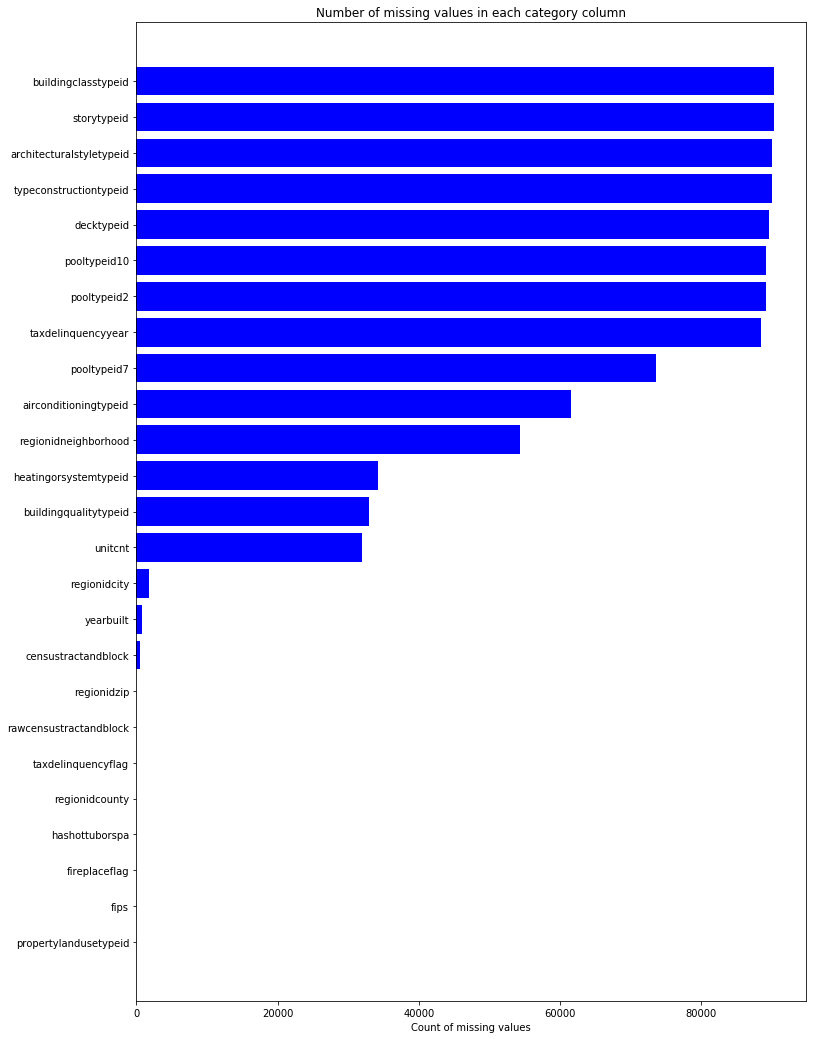

In [18]:
fig, ax = plt.subplots(figsize=(12,18))
ax.barh(np.arange(nan_c_train.shape[0]), nan_c_train.missing_counts.values, color='blue')
ax.set_yticks(np.arange(nan_c_train.shape[0]))
ax.set_yticklabels(nan_c_train.column_name.values, rotation="horizontal")
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each category column")

In [19]:
nan_c_train["rateofNaN"] = nan_c_train["missing_counts"] / 90275
nan_c_train[nan_c_train["rateofNaN"] > 0.5]

,column_name,missing_counts,rateofNaN
18,regionidneighborhood,54263,0.601086
0,airconditioningtypeid,61494,0.681185
11,pooltypeid7,73578,0.815043
24,taxdelinquencyyear,88492,0.980249
10,pooltypeid2,89071,0.986663
9,pooltypeid10,89114,0.987139
4,decktypeid,89617,0.992711
20,typeconstructiontypeid,89976,0.996688
1,architecturalstyletypeid,90014,0.997109
19,storytypeid,90232,0.999524


In [20]:
impute_zero_train = nan_c_train[nan_c_train["rateofNaN"] > 0.5]["column_name"].values
impute_zero_train

array(['regionidneighborhood', 'airconditioningtypeid', 'pooltypeid7',
       'taxdelinquencyyear', 'pooltypeid2', 'pooltypeid10', 'decktypeid',
       'typeconstructiontypeid', 'architecturalstyletypeid', 'storytypeid',
       'buildingclasstypeid'], dtype=object)

In [21]:
train[impute_zero_train].isna().sum()

regionidneighborhood        54263
airconditioningtypeid       61494
pooltypeid7                 73578
taxdelinquencyyear          88492
pooltypeid2                 89071
pooltypeid10                89114
decktypeid                  89617
typeconstructiontypeid      89976
architecturalstyletypeid    90014
storytypeid                 90232
buildingclasstypeid         90259
dtype: int64

In [22]:
train[impute_zero_train] = train[impute_zero_train].fillna(0.0)
train[impute_zero_train].isna().sum()

regionidneighborhood        0
airconditioningtypeid       0
pooltypeid7                 0
taxdelinquencyyear          0
pooltypeid2                 0
pooltypeid10                0
decktypeid                  0
typeconstructiontypeid      0
architecturalstyletypeid    0
storytypeid                 0
buildingclasstypeid         0
dtype: int64

### buildingqualitytypeid

In [23]:
train["buildingqualitytypeid"].value_counts()

7.0     29310
4.0     23839
1.0      2627
10.0     1461
12.0      119
8.0         5
6.0         2
11.0        1
Name: buildingqualitytypeid, dtype: int64

In [24]:
train.loc[train["buildingqualitytypeid"].isna(), "buildingqualitytypeid"] = 7.0
train[train["buildingqualitytypeid"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### heatingorsystemtypeid

In [25]:
train["heatingorsystemtypeid"].value_counts()

2.0     38303
7.0     15519
24.0     1071
6.0       970
20.0       97
13.0       76
18.0       25
1.0        13
14.0        2
10.0        2
11.0        1
12.0        1
Name: heatingorsystemtypeid, dtype: int64

In [26]:
train.loc[train["heatingorsystemtypeid"].isna(), "heatingorsystemtypeid"] = 2.0
train[train["heatingorsystemtypeid"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### censustractandblock

In [27]:
train["censustractandblock"].value_counts().head()

6.037920e+13    62
6.059032e+13    59
6.037137e+13    49
6.059063e+13    46
6.037277e+13    45
Name: censustractandblock, dtype: int64

In [28]:
train.loc[train["censustractandblock"].isna(), "censustractandblock"] = 6.037920e+13
train[train["censustractandblock"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### regionidcity

In [29]:
train["regionidcity"].value_counts().head()

12447.0    20559
46298.0     3000
52650.0     2132
54311.0     2128
5534.0      2035
Name: regionidcity, dtype: int64

In [30]:
train.loc[train["regionidcity"].isna(), "regionidcity"] = 12447.0
train[train["regionidcity"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### regionidzip

In [31]:
train["regionidzip"].value_counts().head()

97319.0    912
96987.0    902
96974.0    824
97329.0    760
97318.0    726
Name: regionidzip, dtype: int64

In [32]:
train.loc[train["regionidzip"].isna(), "regionidzip"] = 97319.0
train[train["regionidzip"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### unitcnt

In [33]:
train["unitcnt"].value_counts()

1.0      54503
2.0       2354
4.0        871
3.0        619
6.0          1
5.0          1
9.0          1
11.0         1
143.0        1
70.0         1
Name: unitcnt, dtype: int64

In [34]:
train.loc[train["unitcnt"].isna(), "unitcnt"] = 1.0
train[train["unitcnt"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### yearbuilt

In [35]:
train["yearbuilt"].value_counts().head()

1955.0    2261
1989.0    2058
1950.0    1994
1954.0    1940
1964.0    1919
Name: yearbuilt, dtype: int64

In [36]:
train.loc[train["yearbuilt"].isna(), "yearbuilt"] = 1955.0
train[train["yearbuilt"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


In [37]:
train[category_columns].isna().sum()

airconditioningtypeid       0
architecturalstyletypeid    0
buildingclasstypeid         0
buildingqualitytypeid       0
decktypeid                  0
fips                        0
fireplaceflag               0
hashottuborspa              0
heatingorsystemtypeid       0
pooltypeid10                0
pooltypeid2                 0
pooltypeid7                 0
propertylandusetypeid       0
rawcensustractandblock      0
censustractandblock         0
regionidcounty              0
regionidcity                0
regionidzip                 0
regionidneighborhood        0
storytypeid                 0
typeconstructiontypeid      0
unitcnt                     0
yearbuilt                   0
taxdelinquencyflag          0
taxdelinquencyyear          0
dtype: int64

### Scalar type data impute using MICE

In [38]:
imp = MICEData(train[scalar_columns])

In [39]:
imp.data.index = train.index
s_train = imp.data
s_train.head()

,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,threequarterbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet6,finishedsquarefeet12,finishedsquarefeet13,...,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,yardbuildingsqft26,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
parcelid,,,,,,,,,,,,,,,,,,,,,
10711738,13.581395,3.0,4.0,3.0,0.008743,0.025963,2538.0,0.453682,2538.0,11.454545,...,0.440739,1.0,0.172343,0.0,0.142101,1.694737,567112.0,245180.0,321932.0,7219.18
10711755,13.581395,3.0,3.0,3.0,0.008743,0.025963,1589.0,0.453682,1589.0,11.454545,...,0.440739,1.0,0.172343,0.0,0.142101,1.694737,459844.0,254691.0,205153.0,6901.09
10711805,13.581395,2.0,3.0,2.0,0.008743,0.025963,2411.0,0.453682,2411.0,11.454545,...,0.440739,1.0,0.172343,0.0,0.142101,1.694737,384787.0,235114.0,149673.0,4876.61
10711816,13.581395,2.0,4.0,2.0,0.008743,0.025963,2232.0,0.453682,2232.0,11.454545,...,0.440739,0.0,0.172343,0.0,0.142101,1.694737,437176.0,262309.0,174867.0,5560.07
10711858,13.581395,2.0,4.0,2.0,0.008743,0.025963,1882.0,0.453682,1882.0,11.454545,...,0.440739,1.0,0.172343,0.0,0.142101,1.694737,382055.0,232037.0,150018.0,4878.25


### Poolcnt only has one value, therefore fill with 0.0 in NaN value column

In [40]:
train["poolcnt"].value_counts()

1.0    17901
Name: poolcnt, dtype: int64

In [41]:
s_train.loc[train["poolcnt"].isna(), "poolcnt"] = 0.0

In [42]:
X_train = pd.concat([train[category_columns], s_train], axis=1)
print(X_train.shape)
print(X_train.isna().sum())
X_train.head()

(90275, 54)
airconditioningtypeid           0
architecturalstyletypeid        0
buildingclasstypeid             0
buildingqualitytypeid           0
decktypeid                      0
fips                            0
fireplaceflag                   0
hashottuborspa                  0
heatingorsystemtypeid           0
pooltypeid10                    0
pooltypeid2                     0
pooltypeid7                     0
propertylandusetypeid           0
rawcensustractandblock          0
censustractandblock             0
regionidcounty                  0
regionidcity                    0
regionidzip                     0
regionidneighborhood            0
storytypeid                     0
typeconstructiontypeid          0
unitcnt                         0
yearbuilt                       0
taxdelinquencyflag              0
taxdelinquencyyear              0
basementsqft                    0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
th

,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,buildingqualitytypeid,decktypeid,fips,fireplaceflag,hashottuborspa,heatingorsystemtypeid,pooltypeid10,...,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,yardbuildingsqft26,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
parcelid,,,,,,,,,,,,,,,,,,,,,
10711738,1.0,0.0,0.0,4.0,0.0,6037.0,0,0,2.0,0.0,...,0.440739,1.0,0.172343,0.0,0.142101,1.694737,567112.0,245180.0,321932.0,7219.18
10711755,1.0,0.0,0.0,4.0,0.0,6037.0,0,0,2.0,0.0,...,0.440739,1.0,0.172343,0.0,0.142101,1.694737,459844.0,254691.0,205153.0,6901.09
10711805,1.0,0.0,0.0,4.0,0.0,6037.0,0,0,2.0,0.0,...,0.440739,1.0,0.172343,0.0,0.142101,1.694737,384787.0,235114.0,149673.0,4876.61
10711816,1.0,0.0,0.0,4.0,0.0,6037.0,0,0,2.0,0.0,...,0.440739,0.0,0.172343,0.0,0.142101,1.694737,437176.0,262309.0,174867.0,5560.07
10711858,1.0,0.0,0.0,4.0,0.0,6037.0,0,0,2.0,0.0,...,0.440739,1.0,0.172343,0.0,0.142101,1.694737,382055.0,232037.0,150018.0,4878.25


### Add dates columns

In [43]:
X_train["logerror"] = train["logerror"].values
X_train["transactionyear"] = train["transactionyear"].values
X_train["transactionmonth"] = train["transactionmonth"].values
X_train["transactionday"] = train["transactionday"].values

### All of columns is filled

In [44]:
X_train.isna().sum().sum()

0

## Visualizaion

- append logerror columns for correlation heatmap

In [45]:
category_columns.append("logerror")
scalar_columns.append("logerror")
dates_columns.append("logerror")

### Category data heatmap for correlation

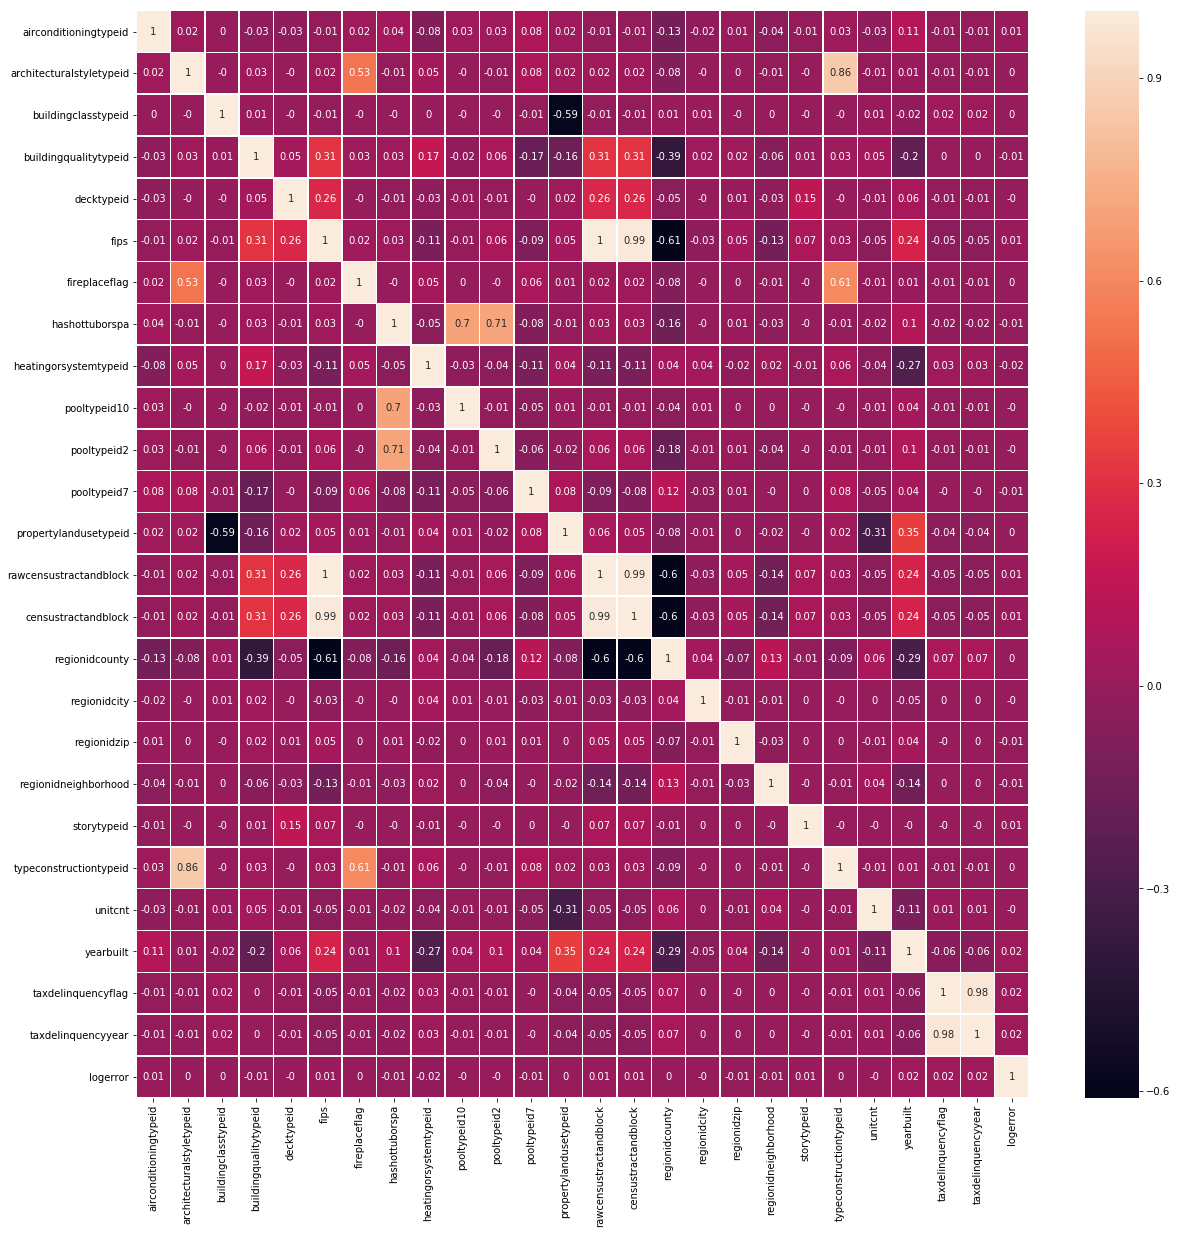

In [46]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(round(X_train[category_columns].corr(),2), linewidths=.5, annot=True, ax=ax)

### Scalar value data heatmap for correlation

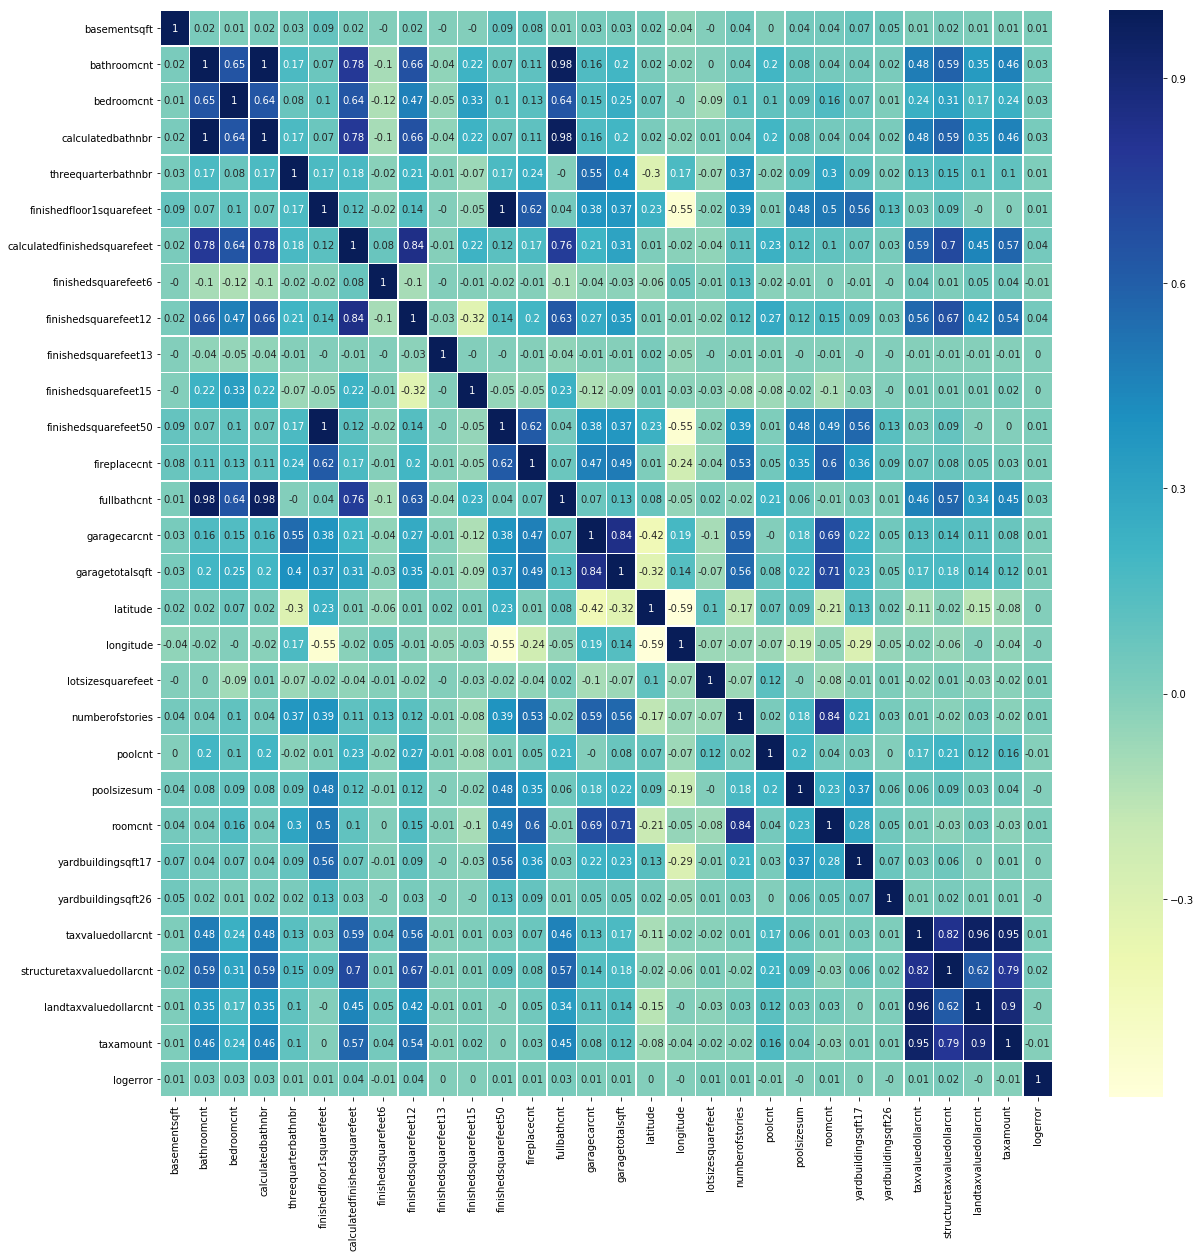

In [47]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(round(X_train[scalar_columns].corr(),2), linewidths=.5, annot=True, ax=ax, cmap="YlGnBu")

### Dates data heatmap for correlation

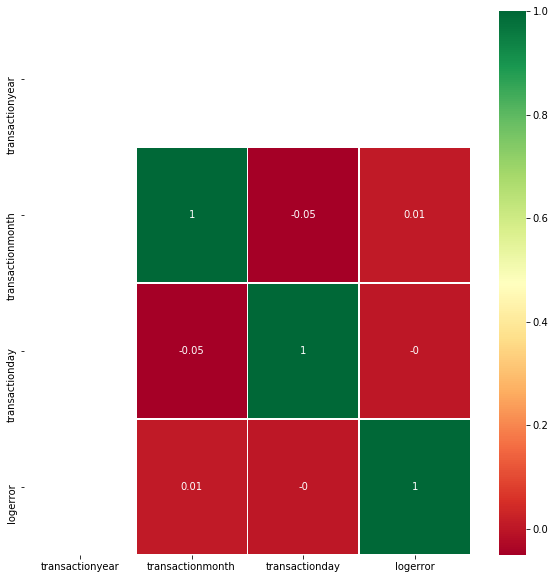

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(round(X_train[dates_columns].corr(),2), linewidths=.5, annot=True, ax=ax, cmap="RdYlGn")

## Column Selection

### Correlation between logerror and specific column is 0, the column isn't selected for training

In [49]:
zero_category_corr = ["architecturalstyletypeid", "buildingclasstypeid", "decktypeid", "fireplaceflag", "pooltypeid10",\
                      "pooltypeid2", "propertylandusetypeid", "regionidcounty", "regionidcity", "typeconstructiontypeid",\
                      "unitcnt"]

zero_scalar_corr = ["finishedsquarefeet13", "finishedsquarefeet15", "latitude", "longitude", "poolsizesum", "yardbuildingsqft26",\
                    "yardbuildingsqft17", "landtaxvaluedollarcnt"]

zero_dates_corr = ["transactionday", "transactionyear"]

In [50]:
train_category_col = [col for col in category_columns if col not in zero_category_corr]
train_scalar_col = [col for col in scalar_columns if col not in zero_scalar_corr]
train_dates_col = ["transactionmonth"] # [col for col in dates_columns if col not in zero_dates_corr]

train_columns_list = train_category_col + train_scalar_col

In [51]:
train_columns_list.remove('logerror') # list has two logerror, because we use logerror drawing heatmap above
train_columns_list

['airconditioningtypeid',
 'buildingqualitytypeid',
 'fips',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'pooltypeid7',
 'rawcensustractandblock',
 'censustractandblock',
 'regionidzip',
 'regionidneighborhood',
 'storytypeid',
 'yearbuilt',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'threequarterbathnbr',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet6',
 'finishedsquarefeet12',
 'finishedsquarefeet50',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'lotsizesquarefeet',
 'numberofstories',
 'poolcnt',
 'roomcnt',
 'taxvaluedollarcnt',
 'structuretaxvaluedollarcnt',
 'taxamount',
 'logerror']

## X_train

In [52]:
X_train = X_train[train_columns_list]

print(X_train.shape)
X_train.head()

(90275, 36)


,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount,logerror
parcelid,,,,,,,,,,,,,,,,,,,,,
10711738,1.0,4.0,6037.0,0,2.0,1.0,6.037113e+07,6.037113e+13,96339.0,268588.0,...,0.187995,0.478772,11012.0,0.440739,1.0,0.0,567112.0,245180.0,7219.18,0.0276
10711755,1.0,4.0,6037.0,0,2.0,1.0,6.037113e+07,6.037113e+13,96339.0,268588.0,...,0.187995,0.478772,11010.0,0.440739,1.0,0.0,459844.0,254691.0,6901.09,-0.0182
10711805,1.0,4.0,6037.0,0,2.0,1.0,6.037113e+07,6.037113e+13,96339.0,268588.0,...,0.187995,0.478772,11723.0,0.440739,1.0,0.0,384787.0,235114.0,4876.61,-0.1009
10711816,1.0,4.0,6037.0,0,2.0,0.0,6.037113e+07,6.037113e+13,96339.0,268588.0,...,0.187995,0.478772,9002.0,0.440739,0.0,0.0,437176.0,262309.0,5560.07,-0.0121
10711858,1.0,4.0,6037.0,0,2.0,1.0,6.037113e+07,6.037113e+13,96339.0,268588.0,...,0.187995,0.478772,9002.0,0.440739,1.0,0.0,382055.0,232037.0,4878.25,-0.0481


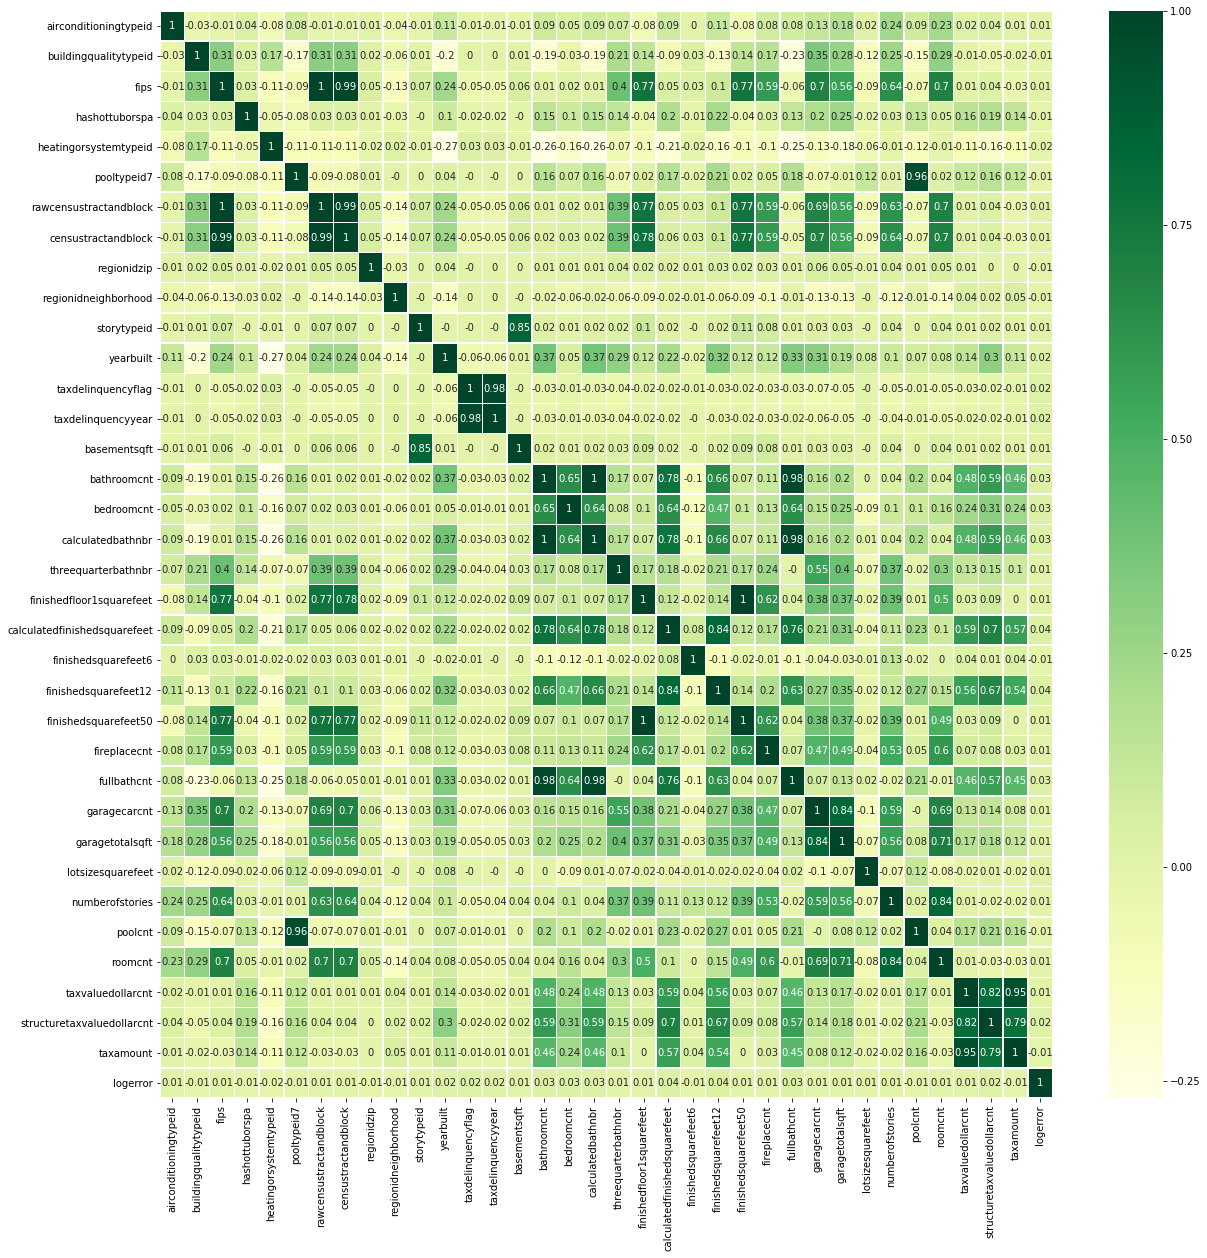

In [53]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(round(X_train.corr(),2), linewidths=.5, annot=True, ax=ax, cmap="YlGn")

In [54]:
len(X_train[round(X_train.corr(),2) > 0.0099].columns)

36

In [55]:
X_train.describe()

,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount,logerror
count,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,90275.00000,90275.000000,...,90275.000000,90275.000000,9.027500e+04,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,90275.000000,90275.000000
mean,0.579086,6.088408,6048.870551,0.026198,3.197065,0.184957,6.049179e+07,6.049076e+13,96586.41532,76051.655575,...,0.726549,114.901768,2.583732e+04,0.668598,0.198294,1.478516,4.576676e+05,1.793353e+05,5983.578211,0.011457
std,1.880576,1.664972,20.663461,0.159724,3.050651,0.388265,2.050549e+05,2.041793e+11,3660.65769,140491.519175,...,0.841116,223.677479,1.150425e+05,0.493451,0.398717,2.819627,5.548834e+05,2.090147e+05,6838.823675,0.161079
min,0.000000,1.000000,6037.000000,0.000000,1.000000,0.000000,6.037101e+07,6.037101e+13,95982.00000,0.000000,...,0.000000,0.000000,1.164177e+00,0.440739,0.000000,0.000000,1.262736e+01,6.606252e+00,0.005927,-4.605000
25%,0.000000,4.000000,6037.000000,0.000000,2.000000,0.000000,6.037320e+07,6.037400e+13,96193.00000,0.000000,...,0.187995,0.478772,5.000000e+03,0.440739,0.000000,0.000000,1.990125e+05,8.064100e+04,2872.470000,-0.025300
50%,0.000000,7.000000,6037.000000,0.000000,2.000000,0.000000,6.037620e+07,6.037620e+13,96393.00000,0.000000,...,0.187995,0.478772,6.756000e+03,0.440739,0.000000,0.000000,3.428720e+05,1.315070e+05,4542.440000,0.006000
75%,1.000000,7.000000,6059.000000,0.000000,2.000000,0.000000,6.059042e+07,6.059042e+13,96987.00000,113455.000000,...,2.000000,0.478772,1.039650e+04,0.440739,0.000000,0.000000,5.405890e+05,2.100425e+05,6900.600000,0.039200
max,13.000000,12.000000,6111.000000,1.000000,24.000000,1.000000,6.111009e+07,6.111009e+13,399675.00000,764167.000000,...,24.000000,7339.000000,6.971010e+06,4.000000,1.000000,18.000000,2.775000e+07,9.948100e+06,321936.090000,4.737000


## X_test

In [56]:
print(train_category_col)

['airconditioningtypeid', 'buildingqualitytypeid', 'fips', 'hashottuborspa', 'heatingorsystemtypeid', 'pooltypeid7', 'rawcensustractandblock', 'censustractandblock', 'regionidzip', 'regionidneighborhood', 'storytypeid', 'yearbuilt', 'taxdelinquencyflag', 'taxdelinquencyyear', 'logerror']


In [57]:
print(train_scalar_col)

['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'threequarterbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet6', 'finishedsquarefeet12', 'finishedsquarefeet50', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'numberofstories', 'poolcnt', 'roomcnt', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'taxamount', 'logerror']


In [58]:
# test data does not need to keep logerror
train_category_col.remove("logerror")
train_scalar_col.remove("logerror")
train_columns_list.remove("logerror")
test_columns_list = train_columns_list

X_test = property_2016[test_columns_list].copy()

### Fill NaN in X_test
- **same way of train data**

In [59]:
print(len(X_test.dtypes[X_test.dtypes == object]))
X_test.dtypes[X_test.dtypes == object]

2


hashottuborspa        object
taxdelinquencyflag    object
dtype: object

- hashottuborspa : True or False
- propertycountylandusecode : 240 types
- propertyzoningdesc : 5638 types
- fireplaceflag : True or False
- taxdelinquencyflag : Y / N

**fill nan**
- hashottuborspa : True or False  ----------------------------->    True = 1, NaN = 0(False)
- fireplaceflag : True or False     ----------------------------->   True = 1, NaN = 0(False)
- taxdelinquencyflag : Y / N           ----------------------------->   Y = 1, NaN = 0(N)
- propertycountylandusecode : not yet preprocessing
- propertyzoningdesc : not yet preprocessing

#### hashottuborspa

In [60]:
# hashottuborspa
X_test.loc[~X_test["hashottuborspa"].isna(), "hashottuborspa"] = 1
X_test.loc[X_test["hashottuborspa"].isna(), "hashottuborspa"] = 0

X_test[X_test["hashottuborspa"].isna()]

,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount


In [61]:
# fireplaceflag is not selected column.

#### taxdelinquencyflag

In [62]:
# taxdelinquencyflag
X_test.loc[~X_test["taxdelinquencyflag"].isna(), "taxdelinquencyflag"] = 1
X_test.loc[X_test["taxdelinquencyflag"].isna(), "taxdelinquencyflag"] = 0

X_test[X_test["taxdelinquencyflag"].isna()]

,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount


### Category

In [63]:
print(X_test[train_category_col].shape)
X_test[train_category_col].isna().sum()

(2985217, 14)


airconditioningtypeid     2173698
buildingqualitytypeid     1046729
fips                        11437
hashottuborspa                  0
heatingorsystemtypeid     1178816
pooltypeid7               2499758
rawcensustractandblock      11437
censustractandblock         75126
regionidzip                 13980
regionidneighborhood      1828815
storytypeid               2983593
yearbuilt                   59928
taxdelinquencyflag              0
taxdelinquencyyear        2928753
dtype: int64

In [64]:
nan_X_test = X_test[train_category_col].isnull().sum(axis=0).reset_index()
nan_X_test.columns = ["column_name", "missing_counts"]
nan_X_test = nan_X_test.sort_values(by="missing_counts")
nan_X_test["rateofNaN"] = nan_X_test["missing_counts"] / len(X_test)
nan_X_test

,column_name,missing_counts,rateofNaN
3,hashottuborspa,0,0.000000
12,taxdelinquencyflag,0,0.000000
2,fips,11437,0.003831
6,rawcensustractandblock,11437,0.003831
8,regionidzip,13980,0.004683
11,yearbuilt,59928,0.020075
7,censustractandblock,75126,0.025166
1,buildingqualitytypeid,1046729,0.350637
4,heatingorsystemtypeid,1178816,0.394885
9,regionidneighborhood,1828815,0.612624


Text(0.5,1,'Number of missing values in each category column')

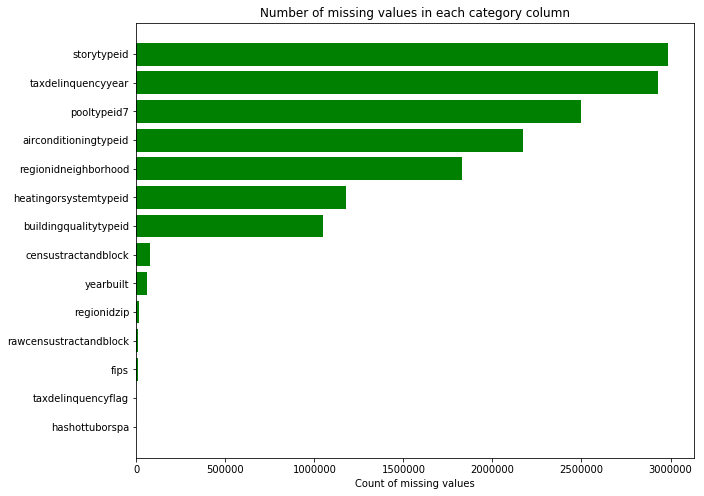

In [65]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(np.arange(nan_X_test.shape[0]), nan_X_test.missing_counts.values, color='green')
ax.set_yticks(np.arange(nan_X_test.shape[0]))
ax.set_yticklabels(nan_X_test.column_name.values, rotation="horizontal")
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each category column")

In [66]:
impute_zero_test = nan_X_test[nan_X_test["rateofNaN"] > 0.5]["column_name"].values
impute_zero_test

array(['regionidneighborhood', 'airconditioningtypeid', 'pooltypeid7',
       'taxdelinquencyyear', 'storytypeid'], dtype=object)

In [67]:
X_test[impute_zero_test] = X_test[impute_zero_test].fillna(0.0)
X_test[impute_zero_test].isna().sum()

regionidneighborhood     0
airconditioningtypeid    0
pooltypeid7              0
taxdelinquencyyear       0
storytypeid              0
dtype: int64

### heatingorsystemtypeid

In [68]:
X_test["heatingorsystemtypeid"].value_counts().head()

2.0     1156830
7.0      595453
6.0       27480
24.0      21107
20.0       3216
Name: heatingorsystemtypeid, dtype: int64

In [69]:
X_test.loc[X_test["heatingorsystemtypeid"].isna(), "heatingorsystemtypeid"] = 2.0
X_test[X_test["heatingorsystemtypeid"].isna()]

,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount


### buildingqualitytypeid

In [70]:
X_test["buildingqualitytypeid"].value_counts().head()

7.0     1133238
4.0      692160
1.0       69467
10.0      39713
12.0       3692
Name: buildingqualitytypeid, dtype: int64

In [71]:
X_test.loc[X_test["buildingqualitytypeid"].isna(), "buildingqualitytypeid"] = 7.0
X_test[X_test["buildingqualitytypeid"].isna()]

,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount


### censustractandblock

In [72]:
X_test["censustractandblock"].value_counts().head()

6.037920e+13    1171
6.037137e+13     881
6.037920e+13     811
6.059063e+13     807
6.059052e+13     806
Name: censustractandblock, dtype: int64

In [73]:
X_test.loc[X_test["censustractandblock"].isna(), "censustractandblock"] = 6.037920e+13
X_test[X_test["censustractandblock"].isna()]

,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount


### yearbuilt

In [74]:
X_test["yearbuilt"].value_counts().head()

1955.0    88586
1950.0    76142
1954.0    73307
1953.0    67085
1956.0    65736
Name: yearbuilt, dtype: int64

In [75]:
X_test.loc[X_test["yearbuilt"].isna(), "yearbuilt"] = 1955.0
X_test[X_test["yearbuilt"].isna()]

,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount


### regionidzip

In [76]:
X_test["regionidzip"].value_counts().head()

96987.0    22021
96193.0    21759
97118.0    20612
97319.0    20310
96964.0    19898
Name: regionidzip, dtype: int64

In [77]:
X_test.loc[X_test["regionidzip"].isna(), "regionidzip"] = 96987.0
X_test[X_test["regionidzip"].isna()]

,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount


### rawcensustractandblock

In [78]:
X_test["rawcensustractandblock"].value_counts().head()

6.059052e+07    1518
6.037920e+07    1455
6.059063e+07     895
6.037137e+07     886
6.037577e+07     825
Name: rawcensustractandblock, dtype: int64

In [79]:
X_test.loc[X_test["rawcensustractandblock"].isna(), "rawcensustractandblock"] = 6.059052e+07
X_test[X_test["rawcensustractandblock"].isna()]

,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount


### fips

In [80]:
X_test["fips"].value_counts()

6037.0    2009362
6059.0     741565
6111.0     222853
Name: fips, dtype: int64

In [81]:
X_test.loc[X_test["fips"].isna(), "fips"] = 6037.0
X_test[X_test["fips"].isna()]

,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount


In [82]:
X_test[train_category_col].isna().sum()

airconditioningtypeid     0
buildingqualitytypeid     0
fips                      0
hashottuborspa            0
heatingorsystemtypeid     0
pooltypeid7               0
rawcensustractandblock    0
censustractandblock       0
regionidzip               0
regionidneighborhood      0
storytypeid               0
yearbuilt                 0
taxdelinquencyflag        0
taxdelinquencyyear        0
dtype: int64

### Scalar

#### MICEData delete tuples which have no value. (all of value of tuples is NaN), so Fill it with the most frequent value in advance.

In [83]:
print(X_test[train_scalar_col].isna().T.all().sum())

for col_name in train_scalar_col:
    X_test.loc[X_test[train_scalar_col].isna().T.all(), col_name] = property_2016[col_name].mode()[0]
    
X_test.loc[X_test[train_scalar_col].isna().T.all(), train_scalar_col]

11437


,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,threequarterbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet6,finishedsquarefeet12,finishedsquarefeet50,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount


In [84]:
imp = MICEData(X_test[train_scalar_col])

In [85]:
imp.data.head()

,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,threequarterbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet6,finishedsquarefeet12,finishedsquarefeet50,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount
0,1.793953,0.0,0.0,0.200737,0.010009,0.369604,0.162124,0.339439,0.000608,0.055422,...,0.244165,0.176483,0.230643,85768.0,0.401464,0.0,0.0,9.0,0.422834,0.002861
1,1.793953,0.0,0.0,0.200737,0.010009,0.369604,0.162124,0.339439,0.000608,0.055422,...,0.244165,0.176483,0.230643,4083.0,0.401464,0.0,0.0,27516.0,0.422834,0.002861
2,1.793953,0.0,0.0,0.200737,0.010009,0.369604,73026.000000,0.339439,0.000608,0.055422,...,0.244165,0.176483,0.230643,63085.0,0.401464,0.0,0.0,1413387.0,650756.000000,20800.370000
3,1.793953,0.0,0.0,0.200737,0.010009,0.369604,5068.000000,0.339439,0.000608,0.055422,...,0.244165,0.176483,0.230643,7521.0,1.000000,0.0,0.0,1156834.0,571346.000000,14557.570000
4,1.793953,0.0,0.0,0.200737,0.010009,0.369604,1776.000000,0.339439,0.000608,0.055422,...,0.244165,0.176483,0.230643,8512.0,0.401464,0.0,0.0,433491.0,193796.000000,5725.170000


In [86]:
imp.data.index = X_test[train_scalar_col].index
s_test = imp.data
s_test.head()

,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,threequarterbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet6,finishedsquarefeet12,finishedsquarefeet50,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount
0,1.793953,0.0,0.0,0.200737,0.010009,0.369604,0.162124,0.339439,0.000608,0.055422,...,0.244165,0.176483,0.230643,85768.0,0.401464,0.0,0.0,9.0,0.422834,0.002861
1,1.793953,0.0,0.0,0.200737,0.010009,0.369604,0.162124,0.339439,0.000608,0.055422,...,0.244165,0.176483,0.230643,4083.0,0.401464,0.0,0.0,27516.0,0.422834,0.002861
2,1.793953,0.0,0.0,0.200737,0.010009,0.369604,73026.000000,0.339439,0.000608,0.055422,...,0.244165,0.176483,0.230643,63085.0,0.401464,0.0,0.0,1413387.0,650756.000000,20800.370000
3,1.793953,0.0,0.0,0.200737,0.010009,0.369604,5068.000000,0.339439,0.000608,0.055422,...,0.244165,0.176483,0.230643,7521.0,1.000000,0.0,0.0,1156834.0,571346.000000,14557.570000
4,1.793953,0.0,0.0,0.200737,0.010009,0.369604,1776.000000,0.339439,0.000608,0.055422,...,0.244165,0.176483,0.230643,8512.0,0.401464,0.0,0.0,433491.0,193796.000000,5725.170000


In [87]:
X_test["poolcnt"].value_counts()

1.0    517534
Name: poolcnt, dtype: int64

In [88]:
s_test.loc[X_test["poolcnt"].isna(), "poolcnt"] = 0.0

In [89]:
X_test = pd.concat([X_test[train_category_col], s_test], axis=1)
print(X_test.shape)
print(X_test.isna().sum())
X_test.head()

(2985217, 35)
airconditioningtypeid           0
buildingqualitytypeid           0
fips                            0
hashottuborspa                  0
heatingorsystemtypeid           0
pooltypeid7                     0
rawcensustractandblock          0
censustractandblock             0
regionidzip                     0
regionidneighborhood            0
storytypeid                     0
yearbuilt                       0
taxdelinquencyflag              0
taxdelinquencyyear              0
basementsqft                    0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
threequarterbathnbr             0
finishedfloor1squarefeet        0
calculatedfinishedsquarefeet    0
finishedsquarefeet6             0
finishedsquarefeet12            0
finishedsquarefeet50            0
fireplacecnt                    0
fullbathcnt                     0
garagecarcnt                    0
garagetotalsqft                 0
lotsizesquarefeet               0


,airconditioningtypeid,buildingqualitytypeid,fips,hashottuborspa,heatingorsystemtypeid,pooltypeid7,rawcensustractandblock,censustractandblock,regionidzip,regionidneighborhood,...,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,numberofstories,poolcnt,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount
0,0.0,7.0,6037.0,0,2.0,0.0,6.037800e+07,6.037920e+13,96337.0,0.0,...,0.244165,0.176483,0.230643,85768.0,0.401464,0.0,0.0,9.0,0.422834,0.002861
1,0.0,7.0,6037.0,0,2.0,0.0,6.037800e+07,6.037920e+13,96337.0,0.0,...,0.244165,0.176483,0.230643,4083.0,0.401464,0.0,0.0,27516.0,0.422834,0.002861
2,0.0,7.0,6037.0,0,2.0,0.0,6.037703e+07,6.037920e+13,96095.0,0.0,...,0.244165,0.176483,0.230643,63085.0,0.401464,0.0,0.0,1413387.0,650756.000000,20800.370000
3,0.0,7.0,6037.0,0,2.0,0.0,6.037141e+07,6.037920e+13,96424.0,27080.0,...,0.244165,0.176483,0.230643,7521.0,1.000000,0.0,0.0,1156834.0,571346.000000,14557.570000
4,0.0,7.0,6037.0,0,2.0,0.0,6.037123e+07,6.037920e+13,96450.0,46795.0,...,0.244165,0.176483,0.230643,8512.0,0.401464,0.0,0.0,433491.0,193796.000000,5725.170000


In [90]:
X_test.isna().sum().sum()

0

## Y_train

In [91]:
y_train = X_train["logerror"]
print(y_train.shape)
y_train[:10]

(90275,)


parcelid
10711738    0.0276
10711755   -0.0182
10711805   -0.1009
10711816   -0.0121
10711858   -0.0481
10711910    0.2897
10712086    0.0040
10712162   -0.0121
10712163    0.0139
10712195   -0.0450
Name: logerror, dtype: float64

## model

In [92]:
# X_train has logerror columns
print(X_train.shape)
print(X_test.shape)

# remove logerror of X_train
X_train.drop("logerror", inplace=True, axis=1)
X_train.shape

(90275, 36)
(2985217, 35)


(90275, 35)

In [93]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(n_jobs=6, normalize=True)

model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=6, normalize=True)

In [94]:
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=6, normalize=True)

In [95]:
model.coef_

array([  4.04809660e-06,   2.04394019e-04,   7.78507180e-03,
        -1.19412238e-02,  -8.33822407e-04,   4.46280889e-05,
        -8.49882503e-07,   6.95893465e-14,  -3.46609422e-07,
        -3.50314774e-09,  -1.97468530e-03,   3.97746100e-05,
         3.49775393e-02,  -7.43929150e-04,   8.70337803e-05,
        -1.69153187e-02,   3.19011697e-04,  -3.07657892e-01,
         1.60944982e-01,   1.54093844e-05,   8.06714707e-06,
        -1.55040373e-05,   5.42400572e-06,  -1.40602964e-05,
        -3.33100764e-03,   3.22268375e-01,  -2.23997799e-03,
        -1.03416643e-05,   1.09591720e-08,   9.49251781e-04,
        -9.70402993e-03,   4.25509075e-04,   2.90729277e-08,
         1.55554118e-08,  -3.50645046e-06])

In [96]:
predict_y_2016 = model.predict(X_test)
predict_y_2016

array([ 0.01543802,  0.0153434 ,  0.58348795, ..., -0.03681851,
       -0.03681851, -0.03681851])

## submission

In [97]:
submission = pd.read_csv("sample_submission.csv")

In [98]:
submission["201610"] = predict_y_2016
submission["201611"] = predict_y_2016
submission["201612"] = predict_y_2016
submission["201710"] = predict_y_2016
submission["201711"] = predict_y_2016
submission["201712"] = predict_y_2016

submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.015438,0.015438,0.015438,0.015438,0.015438,0.015438
1,10759547,0.015343,0.015343,0.015343,0.015343,0.015343,0.015343
2,10843547,0.583488,0.583488,0.583488,0.583488,0.583488,0.583488
3,10859147,0.052703,0.052703,0.052703,0.052703,0.052703,0.052703
4,10879947,0.029692,0.029692,0.029692,0.029692,0.029692,0.029692


In [99]:
submission.to_csv("submission_2016.csv", index=False)